In [30]:
from statistics import linear_regression

import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import LinearRegression as ls
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
import seaborn as sns


from analysis import Analysis

In [22]:
#data explanation
analyzer = Analysis()
data = analyzer.loadData('data/raw_data/zal_hausing.csv')
print(data.head().to_string())
analyzer.findMissingValues(data)
data = data.drop(columns=['zainter'])

   pietro  izby  powierzchnia  zadrzewienie   autostrada   przemysł     centrum     jezioro        lasy     tramwaj     policja      szkola     cena  zainter
0       0     4         65.10         13.44   3153.81100   63.63961  7366.52600  1384.37700   538.56290   472.70500  2996.06800  1324.84000  4531.49    False
1       3     2         32.70         21.56   8452.07227  134.35030  2818.24414  1601.85046  1471.20703    96.04687  1860.02686   289.87067  1972.32     True
2       0     3         40.98          1.20   6571.53900   89.44272  2269.05800  1264.80200   798.82730    40.31129   734.20030   261.72500  2037.58     True
3       3     2         49.53          0.48  11763.63574  207.00241  5615.26953  5416.94092   236.48466  2214.45825  2338.56787   182.48288  5471.43    False
4       4     3         81.40         21.72   4384.95500  169.18920  2375.39500  3475.80900  2024.84600   317.56890  1301.76800    65.00000  3482.80     True
No missing values.


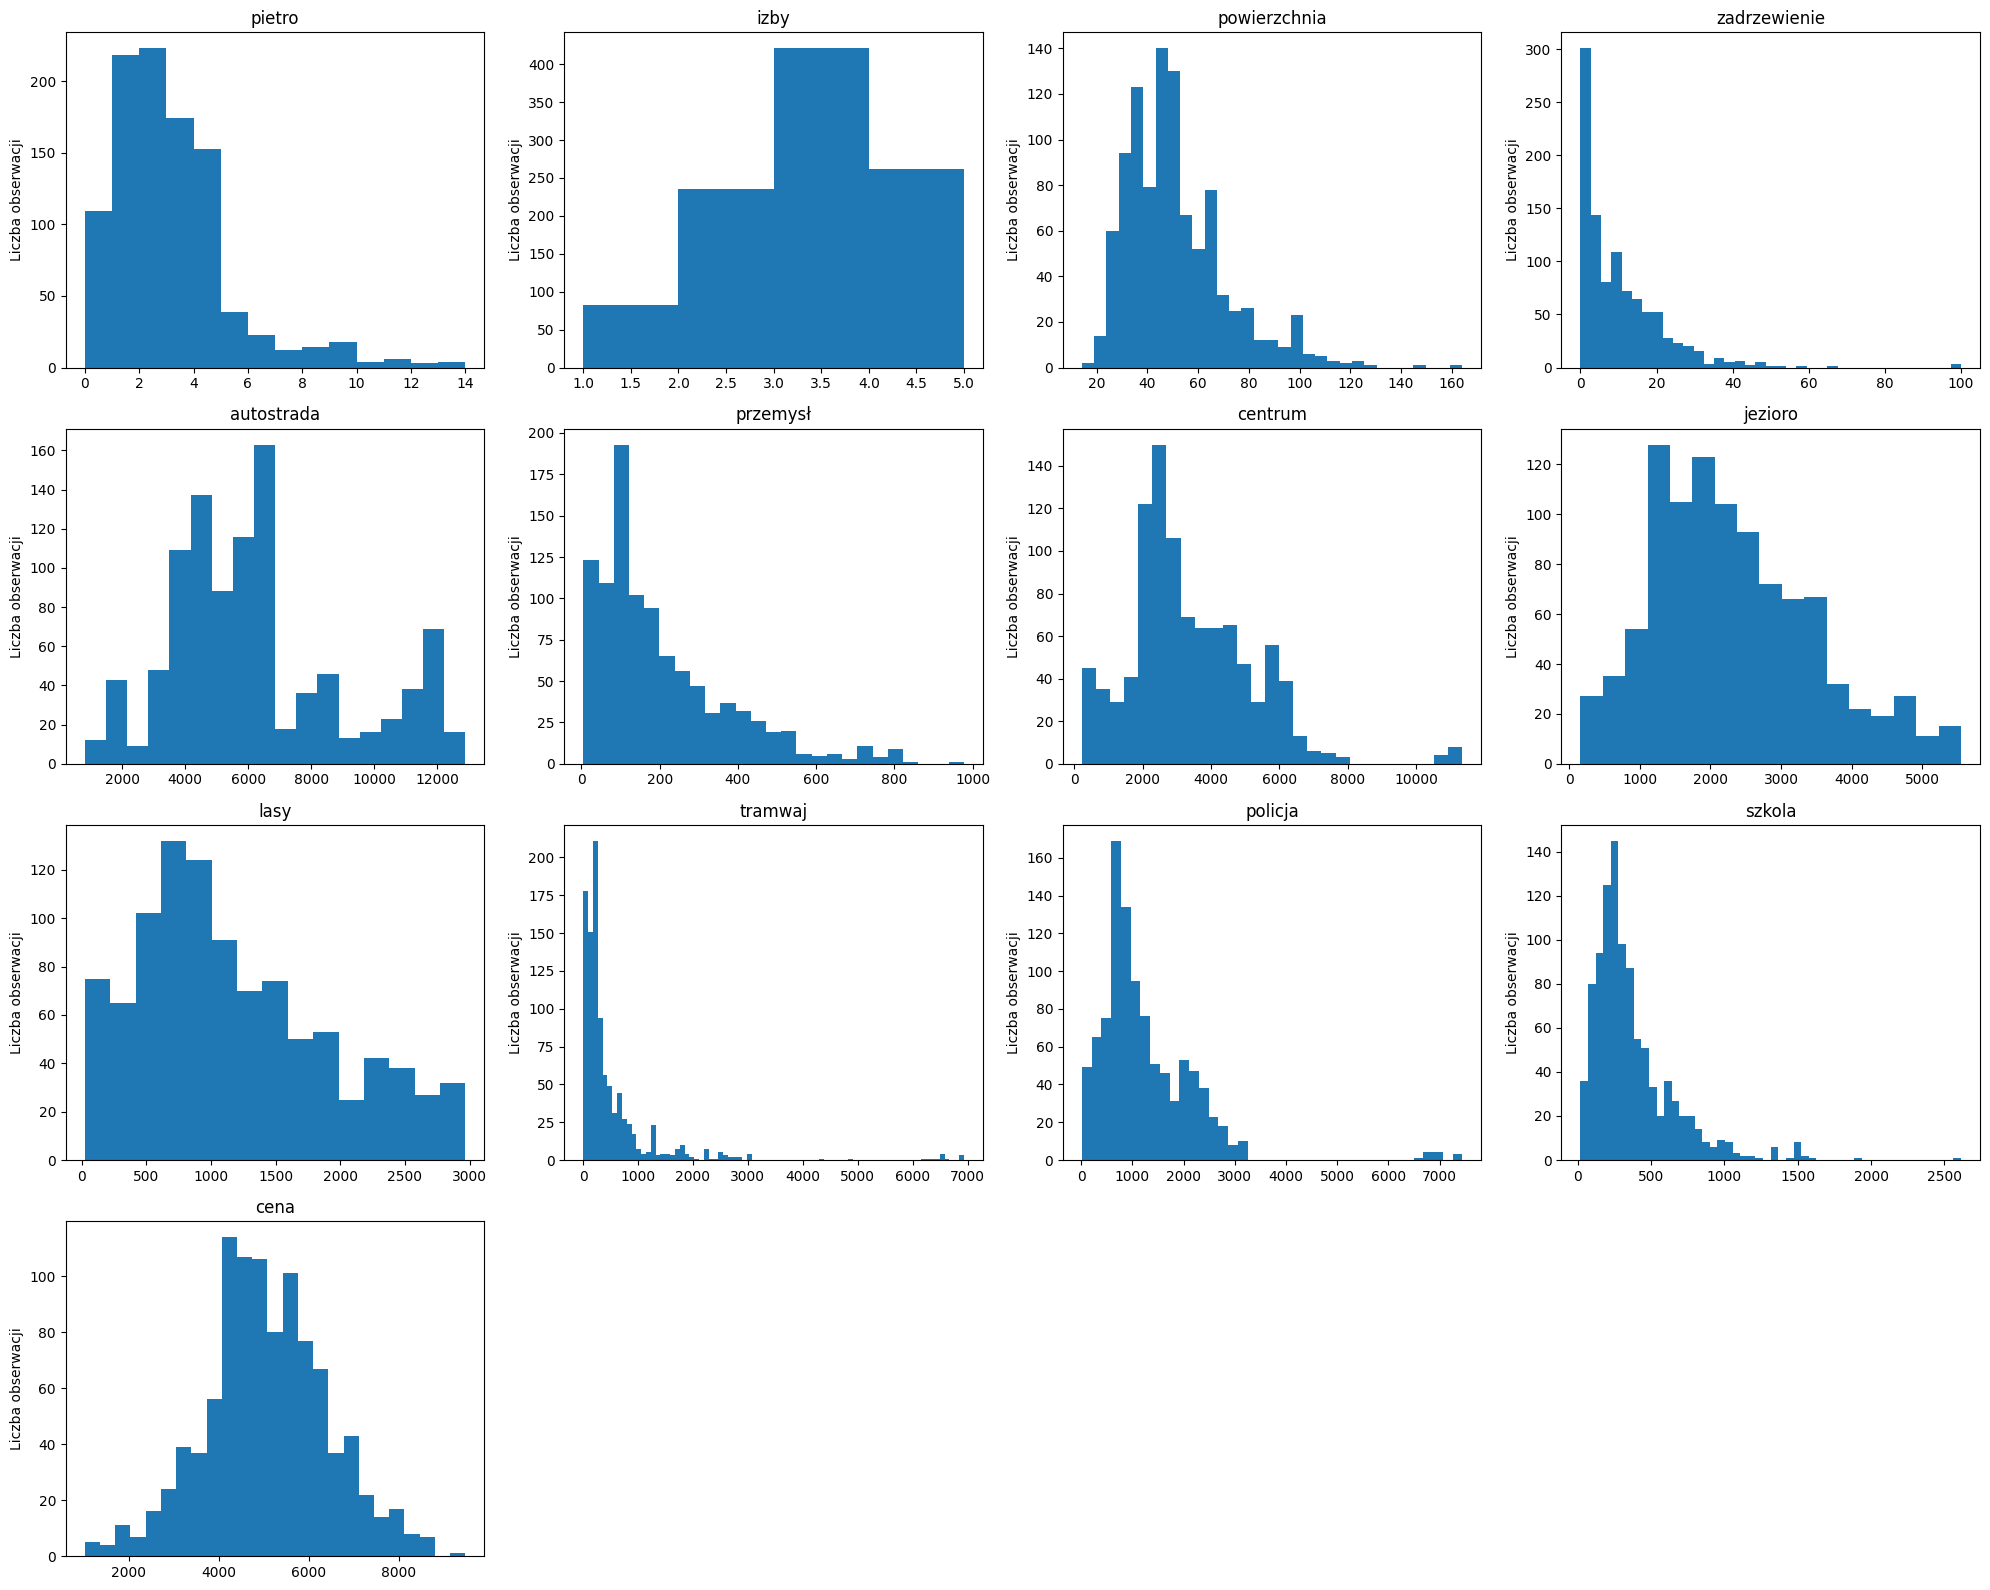

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    axes[i].hist(data[column].dropna(), bins='auto')
    axes[i].set_title(column)
    axes[i].set_ylabel("Liczba obserwacji")

for j in range(13, 16):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


MAPE (OLS): 22.99%


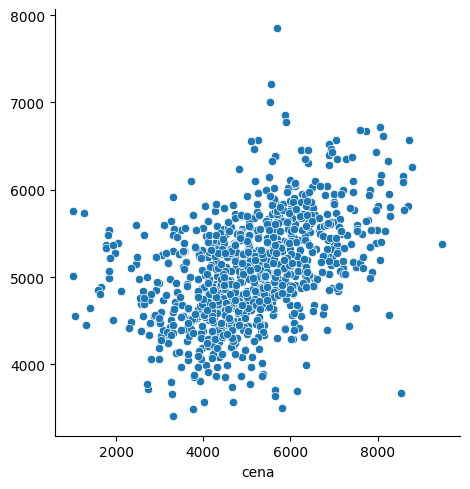

In [24]:
# X - wszystkie kolumny oprócz przedostatniej i ostatniej
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Model OLS
model_o = ls().fit(X, y)

# Predykcja
yhat = model_o.predict(X)

# MAPE
mape_o = mean_absolute_percentage_error(y, yhat)
print(f"MAPE (OLS): {mape_o:.2%}")
sns.relplot(x=y,y=yhat)

[[-1.20708907  1.08840512  0.70037661 ... -0.0580448   1.82192168
   3.39407195]
 [ 0.1416138  -0.92529538 -0.94226942 ... -0.49174508  0.63868533
  -0.28019535]
 [-1.20708907  0.08155487 -0.5224821  ... -0.55592141 -0.53391209
  -0.38011591]
 ...
 [-1.20708907  0.08155487 -0.38458095 ... -0.33266874  0.18137702
  -0.5312762 ]
 [ 0.1416138  -0.92529538 -0.28318305 ... -0.58413164 -0.41330166
   0.23676471]
 [-0.30795382  0.08155487 -0.7496134  ... -0.44509077 -1.06282427
   1.0065539 ]]
2.0167656034134787


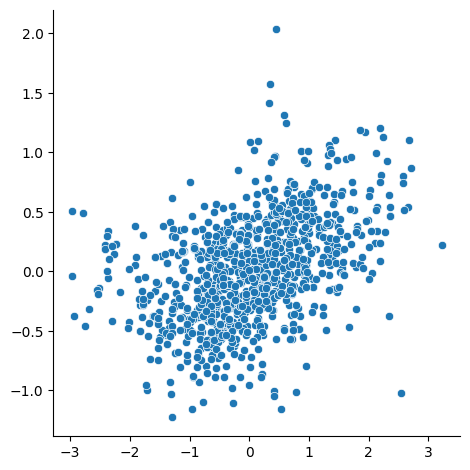

In [26]:

# skalowanie zmiennych
scaler = StandardScaler().fit(data)
scaled = scaler.transform(data)
X = scaled[:,:-1]
y = scaled[:,-1]
model_s = ls().fit(X,y)
yhat = model_s.predict(X)
mape_s = mean_absolute_percentage_error(y,yhat)
print(mape_s)
sns.relplot(x=y,y=yhat)


2.5603643572840835


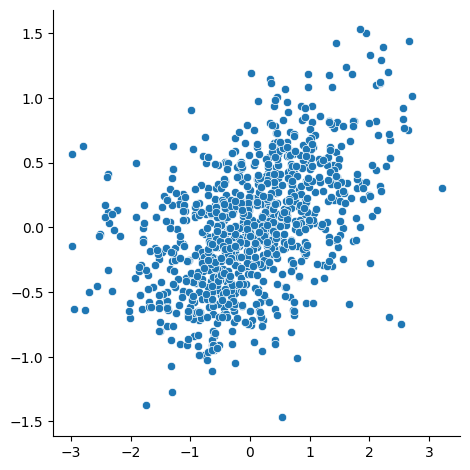

In [29]:
# transformacja potęgowa
transformer_p = PowerTransformer().fit(data)
transformed = transformer_p.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_p = ls().fit(X,y)
yhat = model_p.predict(X)
mape_p = mean_absolute_percentage_error(y,yhat)
print(mape_p)
sns.relplot(x=y,y=yhat)

2881324208785.967


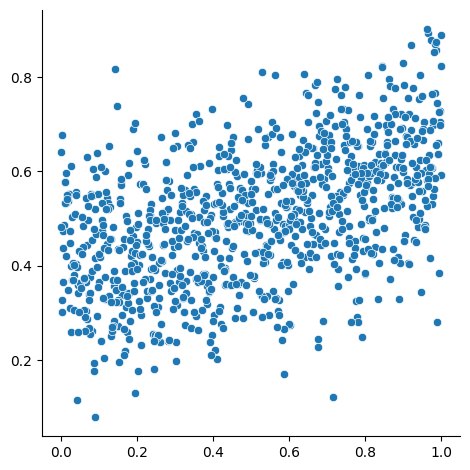

In [31]:
transformer_q = QuantileTransformer().fit(data)
transformed = transformer_q.transform(data)
X = transformed[:,:-1]
y = transformed[:,-1]
model_q = ls().fit(X,y)
yhat = model_q.predict(X)
mae_q = mean_absolute_percentage_error(y,yhat)
print(mae_q)
sns.relplot(x=y,y=yhat)
